In [175]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

# 2

In [21]:
query = """
SELECT count()
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)


In [22]:
df

,count()
0,85207


# 3

In [27]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', ''))
FROM default.ldn_listings
order by id
limit 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,room_type,"toFloat32OrNull(replaceRegexpAll(price, \'[$,]\', \'\'))"
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [29]:
df.groupby('room_type').quantile(q=0.75)

,"toFloat32OrNull(replaceRegexpAll(price, \'[$,]\', \'\'))"
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


# 4

In [32]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(replaceRegexpAll(review_scores_rating, '[$,]', '')) as rating
FROM default.ldn_listings
Having rating > 0
order by id
limit 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,room_type,price,rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [37]:
df_new = df.groupby('room_type',as_index=False).agg({'price':'mean','rating':'mean'})

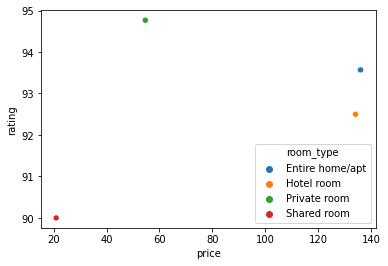

In [41]:
sns.scatterplot(data=df_new,x='price',y='rating',hue='room_type')

# 5

In [124]:
query = """
SELECT
    DISTINCT host_id, host_verifications
FROM default.ldn_listings
where experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [125]:
x = df.host_verifications[0].strip('[]').replace("'", '').split(', ')
x

['email',
 'phone',
 'facebook',
 'reviews',
 'offline_government_id',
 'selfie',
 'government_id']

In [126]:
df['host_verifications'] = df.host_verifications.apply(lambda x: x.strip('[]').replace("'", '').split(', '))

In [127]:
df

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [128]:
df.host_verifications.explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

# 6

In [130]:
query = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(*) as experiences_count
FROM default.ldn_listings
where experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
limit 100
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [133]:
df_new = df.pivot(index='neighbourhood_cleansed',columns='experiences_offered', values='experiences_count')

In [132]:
cmap=sns.cubehelix_palette(as_cmap=True)

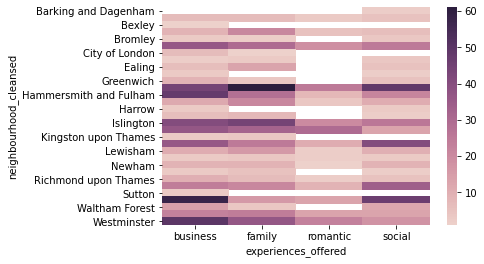

In [136]:
sns.heatmap(df_new,cmap = cmap)

# 7

In [142]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM default.ldn_listings
where experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


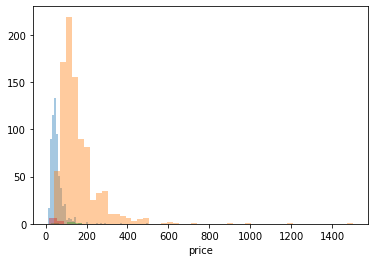

In [154]:
sns.distplot(df.query("room_type=='Private room'").price, kde=False, label='type_1')
sns.distplot(df.query("room_type=='Entire home/apt'").price, kde=False, label='type_2')
sns.distplot(df.query("room_type=='Hotel room'").price, kde=False, label='type_3')
sns.distplot(df.query("room_type=='Shared room'").price, kde=False, label='type_4')

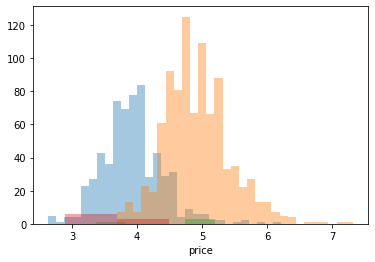

In [153]:
sns.distplot(np.log(df.query("room_type=='Private room'").price), kde=False, label='type_1')
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price), kde=False, label='type_2')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price), kde=False, label='type_3')
sns.distplot(np.log(df.query("room_type=='Shared room'").price), kde=False, label='type_4')

In [139]:
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

# 8

In [171]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM default.ldn_listings
where first_review > '2010-01-01'
limit 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [172]:
df['first_review'] = df.first_review.apply(lambda x: x[:4])

In [159]:
x = df.first_review[0]
x[:4]

'2010'

In [173]:
df = df.astype({'first_review':'int'})

In [174]:
df.dtypes

room_type        object
price           float32
first_review      int64
dtype: object

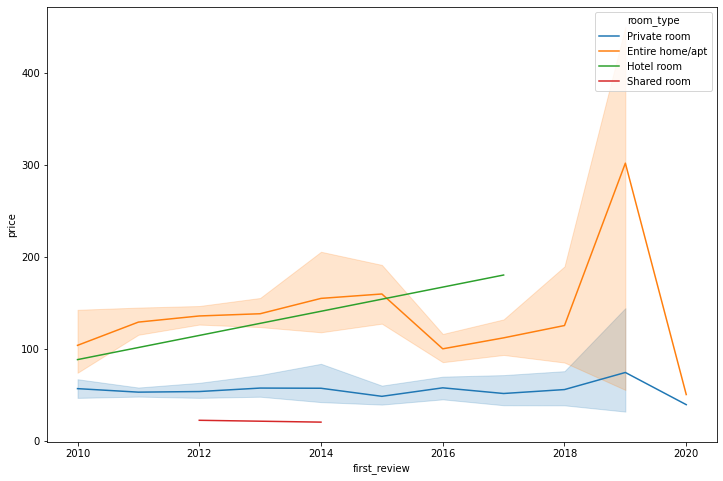

In [176]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=df)